In [1]:
# PyTorch and PyTorch Geometric imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import from_networkx

# NetworkX imports
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import random

# Custom imports
from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from models.models_BA_2grid import GIN_framework as framework

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(37)

Model

In [5]:
MODEL = "GAT"
DATASET = "BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions"

# import the model
from models.models_BA_2grid_house import GAT_Framework_5 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions

In [6]:
# inizialize the framework
dataset = BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions()
gnn = framework(dataset,device="cpu")

/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (conv1): GATConv(10, 128, heads=8)
  (conv2): GATConv(1024, 128, heads=8)
  (conv3): GATConv(1024, 128, heads=8)
  (lin1): Linear(in_features=1024, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions(1600)


In [ ]:
# gnn.iterate()

In [ ]:
#save the model 
# torch.save("models/"+DATASET+"_"+MODEL)

In [8]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

INFO:root:Model loaded from: models/BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions_GAT


we loaded the weights


In [9]:
# train the model
gnn.evaluate()

INFO:root:Train Loss: 0.050, Train Acc: 0.988, Test Loss: 0.097, Test Acc: 0.968


Properties of the graphs

In [12]:
import networkx as nx

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])


In [13]:
#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [14]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

### Probing pipeline 

from extracting features to training a diagnostic classifier

In [15]:
"""
x, x1, x2, x3, x_max_pool, x_2, x_3
"""
train_features, test_features = gnn.evaluate_with_features2()

In [13]:
len(train_features), len(test_features)

(1600, 400)

In [14]:
len(train_features[0])

6

#### Diagnostic classifier

In [18]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x_3, dim=-1), x, x1, x2, x3, x_max_pool, x_2, x_3)
"""

output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component'] #, 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6']

#### Probing pipeline

In [19]:
"""
The embeddings of GAT
return F.log_softmax(x_3, dim=-1), (x1, x2, x3, x_max_pool, x_2, x_3)
"""

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}
ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')
            
            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

Epoch [1000/10000], Property: num_nodes, Loss: 26.1956
Epoch [2000/10000], Property: num_nodes, Loss: 18.4659
Epoch [3000/10000], Property: num_nodes, Loss: 14.3376
Epoch [4000/10000], Property: num_nodes, Loss: 11.0920
Epoch [5000/10000], Property: num_nodes, Loss: 9.1194
Epoch [6000/10000], Property: num_nodes, Loss: 8.3800
Epoch [7000/10000], Property: num_nodes, Loss: 8.2534
Epoch [8000/10000], Property: num_nodes, Loss: 8.2455
Epoch [9000/10000], Property: num_nodes, Loss: 8.2434
Epoch [10000/10000], Property: num_nodes, Loss: 8.2411
Embedding: torch.Size([1600, 1024])
Property: num_nodes
  Train MSE: 8.2411, Test MSE: 8.0499
  Train R²: 0.0021, Test R²: -0.0003
Epoch [1000/10000], Property: num_edges, Loss: 36.6016
Epoch [2000/10000], Property: num_edges, Loss: 25.9673
Epoch [3000/10000], Property: num_edges, Loss: 20.5175
Epoch [4000/10000], Property: num_edges, Loss: 16.0596
Epoch [5000/10000], Property: num_edges, Loss: 12.8309
Epoch [6000/10000], Property: num_edges, Loss: 11

Epoch [4000/10000], Property: avg_path_len, Loss: 0.2464
Epoch [5000/10000], Property: avg_path_len, Loss: 0.2435
Epoch [6000/10000], Property: avg_path_len, Loss: 0.2429
Epoch [7000/10000], Property: avg_path_len, Loss: 0.2426
Epoch [8000/10000], Property: avg_path_len, Loss: 0.2425
Epoch [9000/10000], Property: avg_path_len, Loss: 0.2425
Epoch [10000/10000], Property: avg_path_len, Loss: 0.2425
Embedding: torch.Size([1600, 1024])
Property: avg_path_len
  Train MSE: 0.2425, Test MSE: 0.2480
  Train R²: 0.0069, Test R²: -0.0086
Epoch [1000/10000], Property: num_cliques, Loss: 42.8947
Epoch [2000/10000], Property: num_cliques, Loss: 33.4437
Epoch [3000/10000], Property: num_cliques, Loss: 27.4996
Epoch [4000/10000], Property: num_cliques, Loss: 24.0570
Epoch [5000/10000], Property: num_cliques, Loss: 20.9696
Epoch [6000/10000], Property: num_cliques, Loss: 17.9226
Epoch [7000/10000], Property: num_cliques, Loss: 15.2096
Epoch [8000/10000], Property: num_cliques, Loss: 13.1746
Epoch [900

Epoch [5000/10000], Property: num_squares, Loss: 0.0464
Epoch [6000/10000], Property: num_squares, Loss: 0.0463
Epoch [7000/10000], Property: num_squares, Loss: 0.0463
Epoch [8000/10000], Property: num_squares, Loss: 0.0462
Epoch [9000/10000], Property: num_squares, Loss: 0.0461
Epoch [10000/10000], Property: num_squares, Loss: 0.0461
Embedding: torch.Size([1600, 1024])
Property: num_squares
  Train MSE: 0.0461, Test MSE: 0.0520
  Train R²: 0.0449, Test R²: -0.0327
Epoch [1000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 15.1938
Epoch [2000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 14.1651
Epoch [3000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.4636
Epoch [4000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12.7055
Epoch [5000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9067
Epoch [6000/10000], 

Epoch [1000/10000], Property: num_edges, Loss: 5.6426
Epoch [2000/10000], Property: num_edges, Loss: 5.0880
Epoch [3000/10000], Property: num_edges, Loss: 4.6999
Epoch [4000/10000], Property: num_edges, Loss: 4.3812
Epoch [5000/10000], Property: num_edges, Loss: 4.0886
Epoch [6000/10000], Property: num_edges, Loss: 3.8315
Epoch [7000/10000], Property: num_edges, Loss: 3.6499
Epoch [8000/10000], Property: num_edges, Loss: 3.5519
Epoch [9000/10000], Property: num_edges, Loss: 3.4317
Epoch [10000/10000], Property: num_edges, Loss: 3.3571
Embedding: torch.Size([1600, 1024])
Property: num_edges
  Train MSE: 3.3574, Test MSE: 4.5264
  Train R²: 0.6871, Test R²: 0.5855
Epoch [1000/10000], Property: density, Loss: 0.0082
Epoch [2000/10000], Property: density, Loss: 0.0032
Epoch [3000/10000], Property: density, Loss: 0.0021
Epoch [4000/10000], Property: density, Loss: 0.0016
Epoch [5000/10000], Property: density, Loss: 0.0014
Epoch [6000/10000], Property: density, Loss: 0.0012
Epoch [7000/10000

Epoch [5000/10000], Property: num_cliques, Loss: 12.3991
Epoch [6000/10000], Property: num_cliques, Loss: 12.3423
Epoch [7000/10000], Property: num_cliques, Loss: 12.2539
Epoch [8000/10000], Property: num_cliques, Loss: 12.1241
Epoch [9000/10000], Property: num_cliques, Loss: 11.9506
Epoch [10000/10000], Property: num_cliques, Loss: 11.7452
Embedding: torch.Size([1600, 20])
Property: num_cliques
  Train MSE: 11.7450, Test MSE: 11.9156
  Train R²: -0.0306, Test R²: -0.0550
Epoch [1000/10000], Property: num_triangles, Loss: 0.1560
Epoch [2000/10000], Property: num_triangles, Loss: 0.1558
Epoch [3000/10000], Property: num_triangles, Loss: 0.1556
Epoch [4000/10000], Property: num_triangles, Loss: 0.1553
Epoch [5000/10000], Property: num_triangles, Loss: 0.1549
Epoch [6000/10000], Property: num_triangles, Loss: 0.1542
Epoch [7000/10000], Property: num_triangles, Loss: 0.1533
Epoch [8000/10000], Property: num_triangles, Loss: 0.1523
Epoch [9000/10000], Property: num_triangles, Loss: 0.1513
E

Epoch [4000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 66.2786
Epoch [5000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 37.9963
Epoch [6000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 18.9139
Epoch [7000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.4200
Epoch [8000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.4210
Epoch [9000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.2372
Epoch [10000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.2011
Embedding: torch.Size([1600, 2])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 8.2010, Test MSE: 8.4451
  Train R²: 0.0070, Test R²: -0.0494


In [20]:
#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(train_properties, f)

In [24]:
results

{('x', 'num_nodes'): (8.241088,
  8.04988,
  0.0021198391914367676,
  -0.00026154518127441406),
 ('x', 'num_edges'): (10.691065,
  10.941986,
  0.0036147236824035645,
  -0.0019240379333496094),
 ('x', 'density'): (0.00023909553,
  0.00022410513,
  0.0015552043914794922,
  -0.003264188766479492),
 ('x', 'avg_path_len'): (0.24253288,
  0.24817124,
  0.006776273250579834,
  -0.009350061416625977),
 ('x', 'num_cliques'): (11.34709,
  11.329148,
  0.0042912960052490234,
  -0.00311434268951416),
 ('x', 'num_triangles'): (0.18793626,
  0.18607639,
  0.007523477077484131,
  -0.005954384803771973),
 ('x', 'num_squares'): (0.048059635,
  0.05067234,
  0.003928780555725098,
  -0.006239652633666992),
 ('x', 'number_of_nodes_in_the_largest_fully_connected_component'): (8.241375,
  8.049565,
  0.0020850300788879395,
  -0.00022232532501220703),
 ('x2', 'num_nodes'): (8.323087,
  8.097922,
  -0.007809162139892578,
  -0.006231069564819336),
 ('x2', 'num_edges'): (10.972247,
  11.040649,
  -0.0225909948

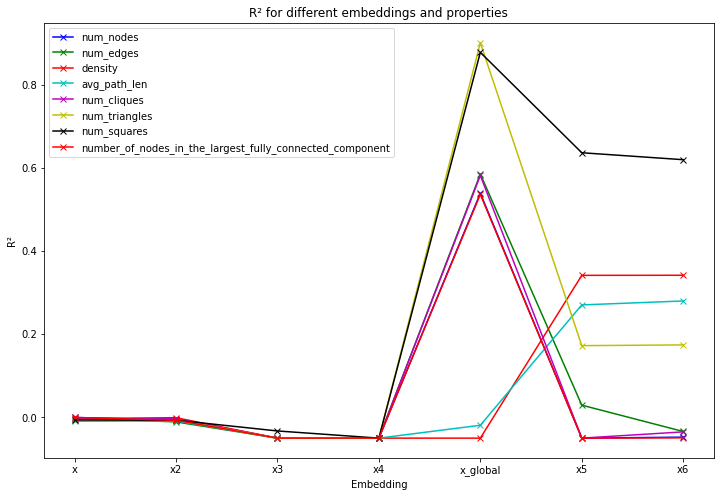

In [26]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'red']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()


### comparison with a gnn train on random (the y are shuffled)

In [ ]:
### comparison with a gnn train on random (the y are shuffled)
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GAT"
DATASET = "BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions_shuffled"

# import the model
from models.models_BA_2grid_house import GAT_Framework_5 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions

print(gnn.model)
print(gnn.train_idx)
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
np.random.shuffle(y)

#make y torch.int64, tensor([0]) instead of [0]
y = torch.tensor(y, dtype=torch.int64)

for i in range(len(dataset)):
    dataset[i].y = y[i]
gnn.iterate()
#save the model 
gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")
gnn.evaluate()
train_features, test_features = gnn.evaluate_with_features2()

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)
"""
The embeddings of GIN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7, x8)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

train_x8 = np.array([feat[8] for feat in train_features])
test_x8 = np.array([feat[8] for feat in test_features])


# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)
train_x8 = torch.tensor(train_x8, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)
test_x8 = torch.tensor(test_x8, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global',  'x6', 'x7', 'x8']
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7', 'x8']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long.png')

### Node embedding probing

This time we will try to probe for node embedding learnt representations. What would make sense is that the GNN uses some node characteristics like the betweeness centrality of some nodes to predict if a graph could contain both a grid and a house. 

##### Node properties

In [2]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_15016\1933910259.py", line 16, in <module>
    train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
NameError: name 'gnn' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  Fi

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
len of features:  4
features[0].shape:  torch.Size([25, 60])
features[1].shape:  torch.Size([25, 60])
features[2].shape:  torch.Size([25, 60])
features[3].shape:  torch.Size([25, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])


In [ ]:
len(train_features), len(test_features)

(1600, 400)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (27, 60)
Feature 2 shape: (27, 60)
Feature 3 shape: (27, 60)
Feature 4 shape: (27, 60)


In [ ]:
train_features[1][0][26]

array([0.11293012, 0.01297014, 0.        , 0.        , 0.00048169,
       0.        , 0.        , 0.11032721, 0.0006601 , 0.        ,
       0.        , 0.00569319, 0.01119991, 0.        , 0.        ,
       0.        , 0.        , 0.1187728 , 0.02496059, 0.        ,
       0.        , 0.        , 0.09984584, 0.        , 0.16730181,
       0.12269668, 0.        , 0.        , 0.13658862, 0.        ,
       0.        , 0.        , 0.        , 0.02736452, 0.        ,
       0.        , 0.        , 0.01627633, 0.        , 0.00716374,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11217522, 0.00050629, 0.        , 0.04717182,
       0.11243994, 0.        , 0.        , 0.        , 0.06470888,
       0.        , 0.        , 0.        , 0.        , 0.        ])

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


R² for local clustering coefficient prediction: [0.4841927549025531, 0.5885748736985221, 0.553935958537314, 0.5937347910192293]
R² for eigenvector centrality prediction: [0.4159696190840295, 0.4910735740692913, 0.5317800215207991, 0.5328035947641372]
R² for node degree prediction: [0.79121277530391, 0.813389031323898, 0.7947223264111095, 0.805799508393025]
R² for betweenness centrality prediction: [0.49523594279566274, 0.53993553609594, 0.5741994943077879, 0.5884060368158552]


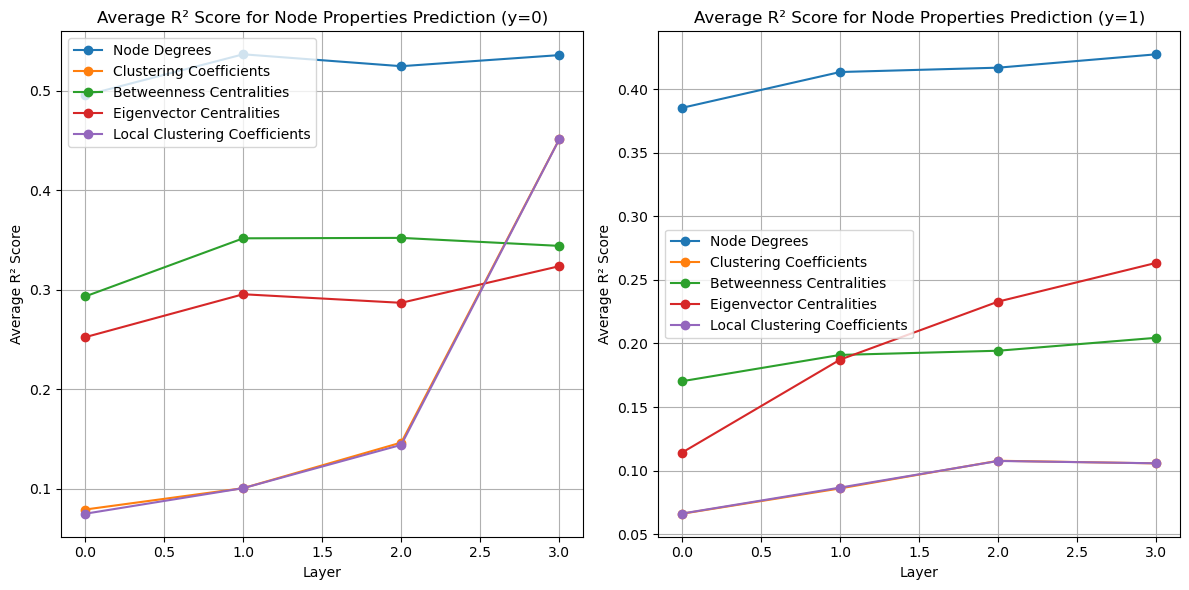

In [ ]:
# Separate the graphs based on labels
def separate_graphs_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, graph in enumerate(gnn.dataset[gnn.train_idx]):
        if graph.y.item() == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

train_features_0, train_properties_0, train_features_1, train_properties_1 = separate_graphs_by_label(train_features, train_node_properties, gnn.dataset[gnn.train_idx])

# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, property_index):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients

properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store R² scores
r2_scores_0 = {name: [] for name in property_names}
r2_scores_1 = {name: [] for name in property_names}

# Compute R² scores for graphs with y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_0, train_properties_0, prop_idx)
    r2_scores_0[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Compute R² scores for graphs with y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_1, train_properties_1, prop_idx)
    r2_scores_1[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Plot the results
layers = np.arange(len(r2_scores_0[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for graphs with y=0
plt.subplot(1, 2, 1)
for prop_name in property_names:
    plt.plot(layers, r2_scores_0[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=0)')
plt.legend()
plt.grid(True)

# Plot for graphs with y=1
plt.subplot(1, 2, 2)
for prop_name in property_names:
    plt.plot(layers, r2_scores_1[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


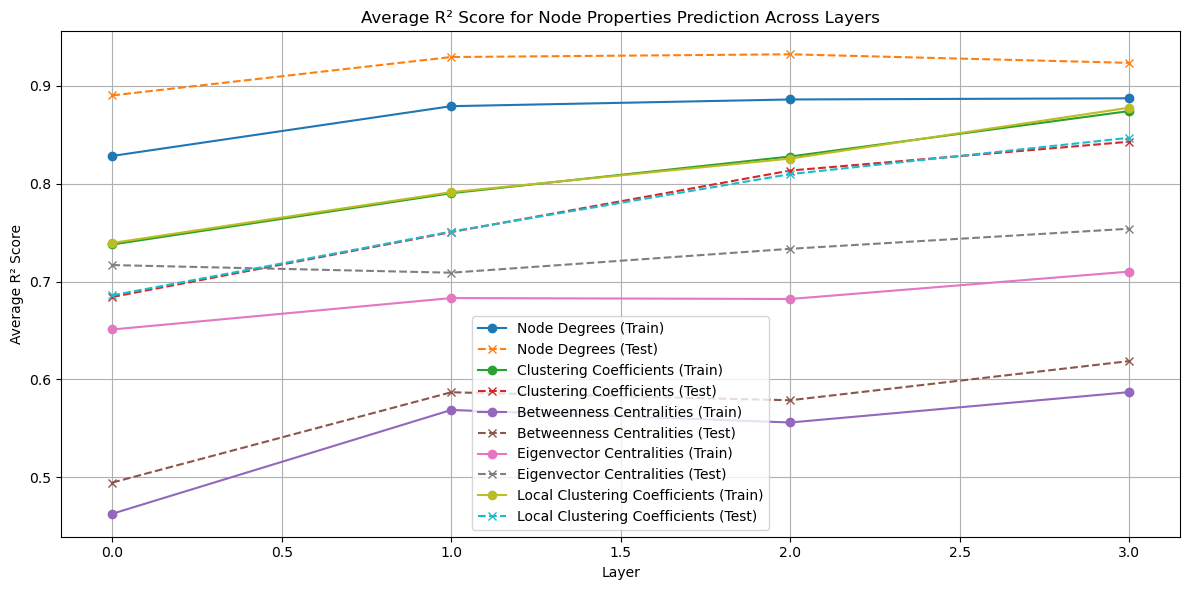

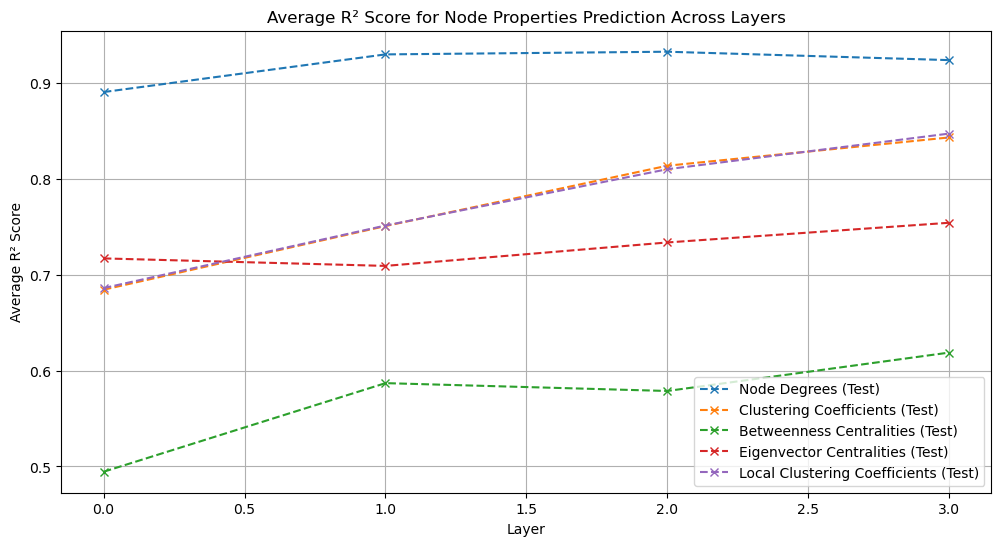

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=1):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

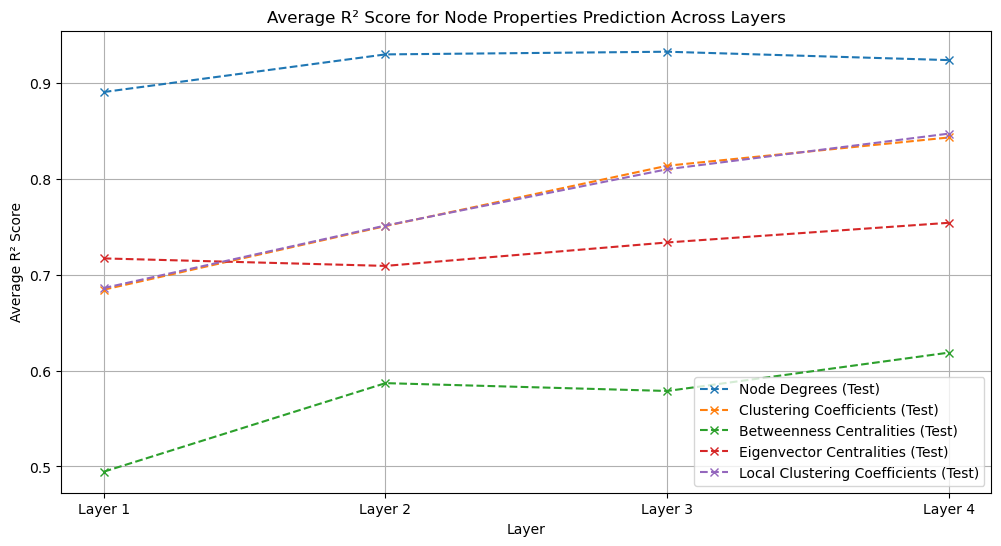

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)